In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from scipy.optimize import minimize
import glob
import os
import sys
import time
from datetime import datetime

from lsst.all_sky_phot.wcs import wcs_zea, wcs_refine_zea, Fisheye, distortion_mapper, distortion_mapper_looper, load_fisheye
from lsst.all_sky_phot import phot_night, readcr2, readYBC, radec2altaz, star2altaz, phot_image, default_phot_params
from lsst.all_sky_phot.star_catalog import read_simbad
from astropy.io import fits
from astropy import wcs
from astropy.wcs import Sip
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, ICRS, Longitude, Latitude
import astropy.units as u
from astropy.time import Time, TimezoneInfo
from astropy.table import Table, vstack
from astropy import units as u
from astropy.stats import sigma_clipped_stats

from photutils import CircularAperture, CircularAnnulus, aperture_photometry

from scipy.spatial import KDTree
import healpy as hp
from lsst.sims.utils import healbin, angularSeparation

from scipy.stats import iqr, binned_statistic
from lsst.sims.utils import healbin

In [2]:
# UT offset for Arizona
utc_offset = 7/24. # in days.

In [3]:
L3_wcs = load_fisheye('L3_wcs_w_shift.npz')

In [4]:
# load up an isolated stellar catalog
bsc = read_simbad(isolate_catalog=True, isolate_radius=20.)

In [5]:
# 
filelist = glob.glob('2018-02-05/*.fits')
filelist.extend(glob.glob('2018-01-26/*.fits'))

In [6]:
# Check the 
filters = []
for filename in filelist:
    hdul = fits.open(filename)
    filters.append(hdul[0].header['FILTERS'])
    hdul.close()

In [7]:
good = np.where(np.array(filters) == 'Filter_L3')

In [8]:
filename = filelist[good[0][0]]
hdul = fits.open(filename)
image = hdul[0].data.copy()
header = hdul[0].header.copy()
hdul.close()

In [9]:
# grab the location from the header
hdu1 = fits.open(filename)
lat = Latitude(hdu1[0].header['SITELAT'][:-3], unit=u.deg)
lon = Longitude(hdu1[0].header['SITELONG'][:-3], unit=u.deg)
elevation = 0.728  #km
PI_backyard = EarthLocation(lat=lat, lon=lon, height=elevation*u.km)
hdu1.close()

In [10]:
# need to loop over every frame and do forced photometry
# Calc where we expect stars
date_string = header['DATE-OBS']
time_obj = Time(date_string, scale='utc')
mjd = time_obj.mjd+utc_offset
alt_cat, az_cat = radec2altaz(bsc['RA'], bsc['dec'], mjd, location=PI_backyard)


In [11]:
good_cat = np.where((alt_cat > 18.1) & (bsc['Vmag'] < 7.5) & (bsc['Vmag'] > 1.))[0]
x_expected, y_expected = L3_wcs.all_world2pix(az_cat[good_cat], alt_cat[good_cat], 0.)
# clean out any random nan's
goodpix = np.where((~np.isnan(x_expected)) &(~np.isnan(y_expected)))[0]
good_cat = good_cat[goodpix]
x_expected = x_expected[goodpix]
y_expected = y_expected[goodpix]
apertures = CircularAperture( (x_expected, y_expected), r=5.)
bkg_aper = CircularAnnulus((x_expected, y_expected), r_in=7., r_out=10.)

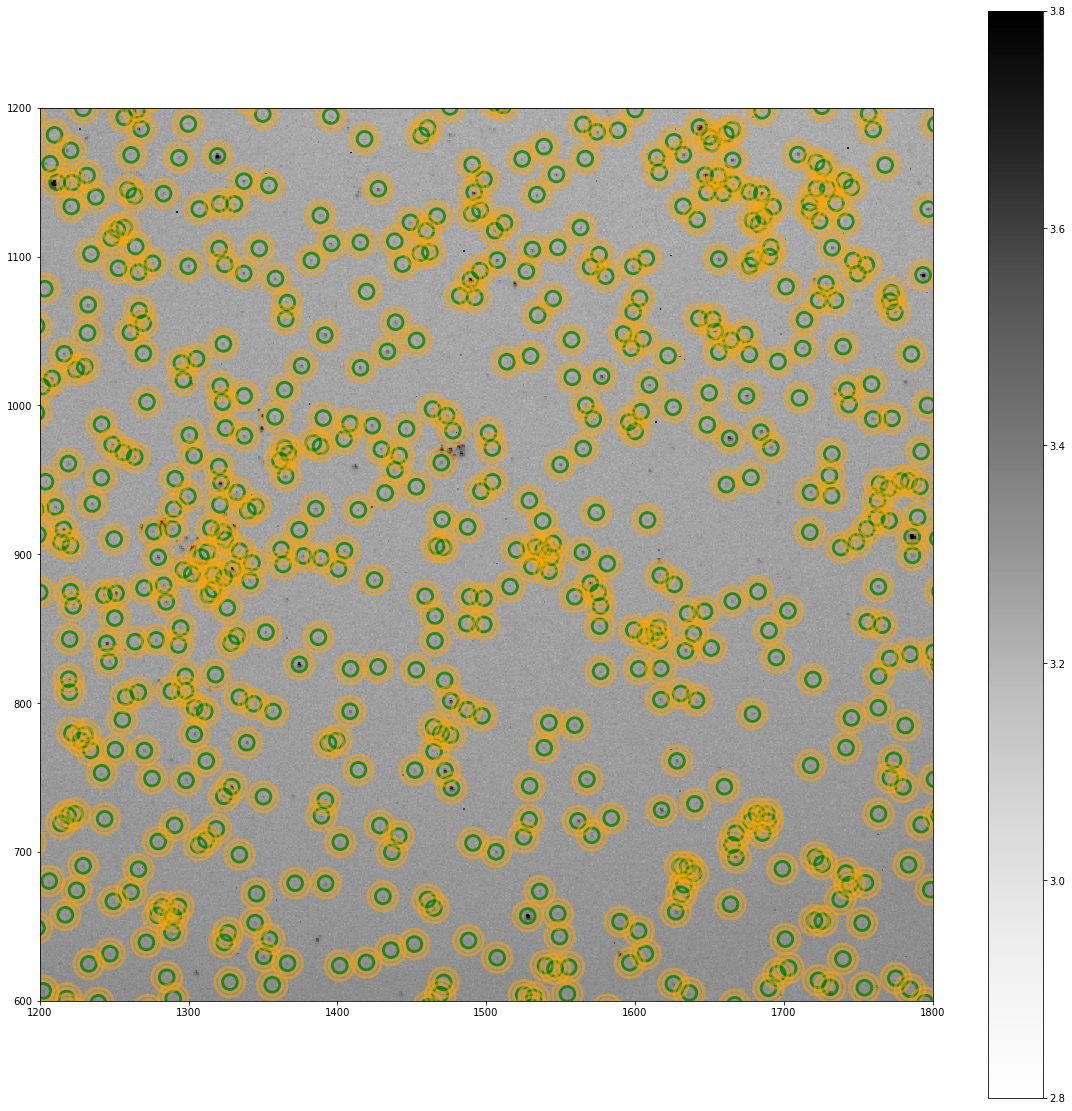

In [12]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(image),  cmap='Greys', origin='lower', vmin=2.8, vmax=3.8)
plt.colorbar()
plt.xlim([1200, 1800])
plt.ylim([600,1200])
# Predicted locations in green
apertures.plot(color='green', lw=3, alpha=0.75)
bkg_aper.plot(color='orange', lw=3, alpha=.5)

In [14]:
# do photometry on the apertures and sky anuli.
forced_table = aperture_photometry(image, [apertures, bkg_aper])
# simple sky subtraction
bkg_mean = forced_table['aperture_sum_1'] / bkg_aper.area()
bkg_sum = bkg_mean * apertures.area()
final_sum = forced_table['aperture_sum_0'] - bkg_sum
forced_table['residual_aperture_sum'] = final_sum


# Let's get the median sigma-clipped backgrounds
# https://github.com/astropy/astropy-workshop/blob/master/09-Photutils/photutils_local_backgrounds.ipynb
bkg_mask = bkg_aper.to_mask(method='center')
bkg_median = []
bkg_mean_clipped = []
for mask in bkg_mask:
    aper_data = mask.multiply(image)
    aper_data = aper_data[mask.data > 0]
    
    # perform a sigma-clipped median
    mean_sigclip, median_sigclip, _ = sigma_clipped_stats(aper_data)
    bkg_median.append(median_sigclip)
    bkg_mean_clipped.append(mean_sigclip)
    
bkg_median = np.array(bkg_median)
mkg_mean_clipped = np.array(bkg_mean_clipped)
# correct for aperture area, subtract the background, and add table columns
forced_table['annulus_median'] = bkg_median
forced_table['aperture_bkg2'] = bkg_median * apertures.area()
forced_table['aperture_sum_bkgsub2'] = forced_table['aperture_sum_0'] - forced_table['aperture_bkg2']


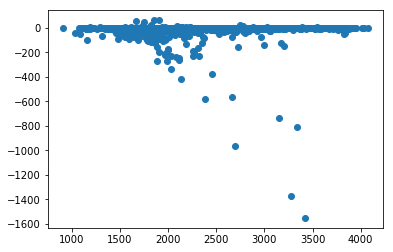

In [15]:
plt.scatter(bkg_mean.data, bkg_mean_clipped- bkg_mean.data)

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


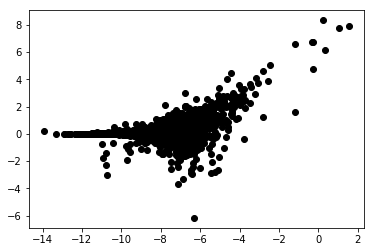

In [28]:
mag_mean = -2.5*np.log10(forced_table['residual_aperture_sum'])
mag_median = -2.5*np.log10(forced_table['aperture_sum_bkgsub2'])
plt.plot(mag_mean, mag_mean-mag_median, 'ko')

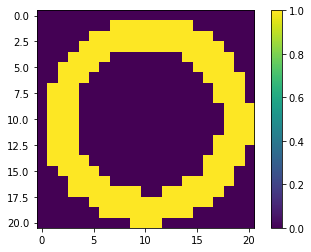

In [19]:
bkg_mask = bkg_aper.to_mask(method='center')
plt.imshow(bkg_mask[0])
plt.colorbar()

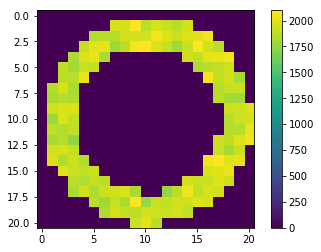

In [20]:
bmask = bkg_mask[0]   # first aperture
data1 = bmask.multiply(image)
plt.imshow(data1)
plt.colorbar()

In [21]:
idx = bmask.data > 0
aper_data = data1[idx]
aper_data.shape

(162,)

(array([  2.,   1.,   5.,   2.,   9.,   7.,  11.,  12.,  12.,  19.,  11.,
         19.,  16.,   6.,   8.,   7.,   3.,   7.,   0.,   5.]),
 array([ 1750. ,  1767.4,  1784.8,  1802.2,  1819.6,  1837. ,  1854.4,
         1871.8,  1889.2,  1906.6,  1924. ,  1941.4,  1958.8,  1976.2,
         1993.6,  2011. ,  2028.4,  2045.8,  2063.2,  2080.6,  2098. ]),
 <a list of 20 Patch objects>)

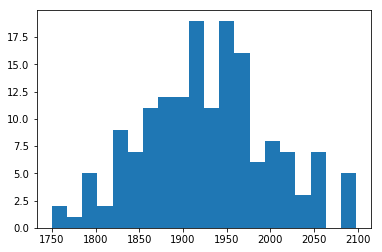

In [22]:
plt.hist(aper_data, bins=20)

In [23]:
np.mean(aper_data), np.median(aper_data)

(1927.5185185185185, 1924.5)

In [24]:
from astropy.stats import sigma_clipped_stats
mean_sigclip, median_sigclip, std_sigclip = sigma_clipped_stats(aper_data)
mean_sigclip, median_sigclip


(1927.5185185185185, 1924.5)

In [25]:
from astropy.stats import biweight_location
biweight_location(aper_data)

1926.3204673633359

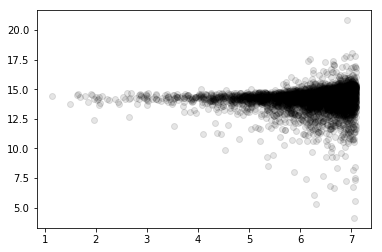

In [26]:
plt.plot(bsc['Vmag'][good_cat], bsc['Vmag'][good_cat]-mag_mean, 'ko', alpha=.1)

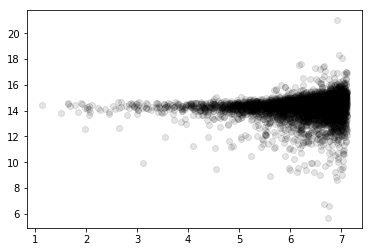

In [27]:
plt.plot(bsc['Vmag'][good_cat], bsc['Vmag'][good_cat]-mag_median, 'ko', alpha=.1)